In [9]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import flopy



In [5]:
# make modflow model
exe_name = "/Users/langevin/langevin/dev/modflow6-fork.git/bin/mf6"
sim_ws = Path("./mf6_vcatch")
name = "vcatch"

Lx = 800.0 + 800.0 + 20.0
Ly = 1000.0
dx = 20.0
nrow = int(Ly / dx)
ncol = int(Lx / dx)
nlay = 1

slope_x = 0.05
slope_y = 0.02

x = np.linspace(-Lx / 2 + dx / 2, Lx / 2 - dx / 2, ncol)
y = np.linspace(Ly - dx / 2, dx / 2, nrow)
X, Y = np.meshgrid(x, y)
land_surface = np.abs(X) * slope_x + Y * slope_y

rough_overland = 0.015
rough_channel = 0.15

rainfall = 3.0e-6  # meters per second
time_rainfall = 90  # minutes
dt0 = 5  # seconds
dtmin = 5
dtmax = 100.0  # seconds
dtadj = 2.0
dtfailadj = 5.0

nper = 2
perlen = nper * [
    time_rainfall * 60.0
]  # convert time_rainfall from minutes to seconds
nstp = nper * [1]
tsmult = nper * [1]

tdis_rc = []
for i in range(nper):
    tdis_rc.append((perlen[i], nstp[i], tsmult[i]))

name = "swf"

# build MODFLOW 6 files
sim = flopy.mf6.MFSimulation(
    sim_name=f"{name}_sim",
    version="mf6",
    exe_name=exe_name,
    sim_ws=sim_ws,
)

# create tdis package
ats_filerecord = None
tdis = flopy.mf6.ModflowTdis(
    sim,
    ats_filerecord=ats_filerecord,
    time_units="SECONDS",
    nper=nper,
    perioddata=tdis_rc,
)

# setup ats
ats_filerecord = name + ".ats"
atsperiod = [
    (0, dt0, dtmin, dtmax, dtadj, dtfailadj),
    (1, dt0, dtmin, dtmax, dtadj, dtfailadj),
]
tdis.ats.initialize(
    maxats=len(atsperiod),
    perioddata=atsperiod,
    filename=ats_filerecord,
)

# surface water model
swfname = f"{name}_model"
swf = flopy.mf6.ModflowSwf(sim, modelname=swfname, save_flows=True)

nouter, ninner = 15, 100
hclose, rclose, relax = 1e-8, 1e-8, 1.0
imsswf = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="DBD",
    under_relaxation_theta=0.9,
    under_relaxation_kappa=0.0001,
    under_relaxation_gamma=0.0,
    inner_maximum=ninner,
    inner_dvclose=hclose,
    linear_acceleration="BICGSTAB",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    # backtracking_number=5,
    # backtracking_tolerance=1.0,
    # backtracking_reduction_factor=0.3,
    # backtracking_residual_limit=100.0,
    filename=f"{swfname}.ims",
)
sim.register_ims_package(imsswf, [swf.name])

botm = land_surface.reshape((nlay, nrow, ncol))
dis = flopy.mf6.ModflowSwfdis(
    swf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=dx,
    delc=dx,
    top=100.0,
    botm=botm,
    xorigin=-810,
)

rough = rough_overland * np.ones((nlay, nrow, ncol), dtype=float)
rough[0, :, int(ncol / 2)] = rough_channel

dfw = flopy.mf6.ModflowSwfdfw(
    swf,
    print_flows=False,
    save_flows=True,
    manningsn=rough,
    idcxs=None,
)

sto = flopy.mf6.ModflowSwfsto(
    swf,
    save_flows=True,
    steady_state={0: False, 1: False},
    transient={0: True, 1: True},
)

ic = flopy.mf6.ModflowSwfic(
    swf,
    strt=botm,
)

# output control
oc = flopy.mf6.ModflowSwfoc(
    swf,
    budget_filerecord=f"{swfname}.bud",
    stage_filerecord=f"{swfname}.stage",
    saverecord=[
        ("STAGE", "ALL"),
        ("BUDGET", "ALL"),
    ],
    printrecord=[
        ("BUDGET", "ALL"),
    ],
)

# flw
qinflow = rainfall * dx * dx
spd = [(0, i, j, qinflow) for j in range(ncol) for i in range(nrow)]
flw = flopy.mf6.ModflowSwfflw(
    swf,
    maxbound=len(spd),
    print_input=True,
    print_flows=True,
    stress_period_data={0: spd, 1: []},
)

# note: for specifying zero-based reach number, put reach number in tuple
fname = f"{swfname}.zdg.obs.csv"
zdg_obs = {
    fname: [
        ("OUTFLOW", "ZDG", (0, nrow - 1, int(ncol / 2))),
    ],
    "digits": 10,
}

idcxs = -1  # use cross section 0
width = dx
spd = [
    ((0, nrow - 1, int(ncol / 2)), idcxs, width, slope_y, rough_channel)
]
zdg = flopy.mf6.ModflowSwfzdg(
    swf,
    observations=zdg_obs,
    print_input=True,
    maxbound=len(spd),
    stress_period_data=spd,
)



In [6]:
# write the model files
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing package swf.ats...
  writing model swf_model...
    writing model name file...
    writing package dis...
    writing package dfw...
    writing package sto...
    writing package ic...
    writing package oc...
    writing package flw_0...
    writing package zdg_0...
    writing package obs_0...


In [7]:
# run the model
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../modflow6-fork.git/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev2 (preliminary) 02/13/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled Mar 25 2024 16:29:23 with GCC version 13.2.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
use of the s

(True, [])

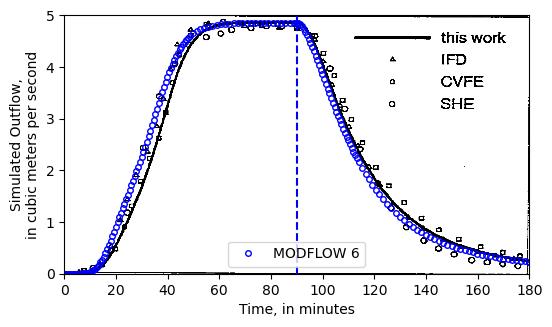

In [30]:
# load background image for comparison
path_to_image = Path("./data/vanderkwaak_fig4-10a.png")
image = Image.open(path_to_image)
image_array = np.array(image)

fpth = sim_ws / f"swf_model.zdg.obs.csv"
obsvals = np.genfromtxt(fpth, names=True, delimiter=",")

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(image_array, interpolation='none', extent=(0, 180, 0, 5))
ax.plot(
    obsvals["time"] / 60.0,
    -obsvals["OUTFLOW"],
    marker="o",
    markersize=4,
    mfc="none",
    mec="b",
    lw=0.0,
    label=f"MODFLOW 6",
)
ax.plot([90, 90], [0, 5], "b--")
ax.set_xlim(0, 180.0)
ax.set_ylim(0, 5)
ax.set_aspect(20)
plt.xlabel("Time, in minutes")
plt.ylabel("Simulated Outflow,\nin cubic meters per second")
plt.legend(loc=8)
fname = Path("../../doc/figures/") / "vcatch.png"
plt.savefig(fname)